<a href="https://colab.research.google.com/github/Ifroza/NLP-Explainable-Detection-of-Online-Sexism/blob/main/CSE440_FULL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional, GlobalAveragePooling1D, SpatialDropout1D
from keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow.keras.activations
from tensorflow.keras.activations import softmax
import sys

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Loading Dataset**

In [6]:
online_sexism_dataset = pd.read_csv("/content/drive/MyDrive/Untitled folder/train_all_tasks.csv")
online_sexism_dataset.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [7]:
#Checking the shape of dataset

online_sexism_dataset.shape

(14000, 5)

# **TASK A**

 **Data Visualization**

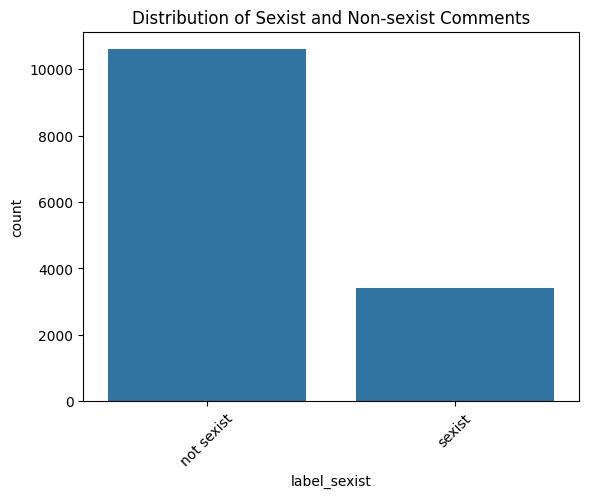

In [8]:
#Checking class balance

sns.countplot(x='label_sexist', data= online_sexism_dataset)
plt.title('Distribution of Sexist and Non-sexist Comments')
plt.xticks(rotation=45)
plt.show()

**Data Preprocessing**

In [9]:
#Checking for Null values in dataset

online_sexism_dataset.isnull().sum()

rewire_id         0
text              0
label_sexist      0
label_category    0
label_vector      0
dtype: int64

In [10]:
# Dropping the columns that are not needed, and keeping only text and label_sexist

online_sexism_dataset = online_sexism_dataset.drop(['rewire_id','label_category', 'label_vector'], axis=1)
online_sexism_dataset.head()

,text,label_sexist
0,"Damn, this writing was pretty chaotic",not sexist
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist
2,How the FUCK is this woman still an MP!!!???,not sexist
3,Understand. Know you're right. At same time I ...,not sexist
4,Surprized they didn't stop and rape some women,not sexist


In [11]:
#Cleaning the data

def preprocess_text(initial_sentence):

    # Converting the given sentence to lowercase
    updated_sentence = initial_sentence.lower()

    # Removal of single character
    updated_sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', updated_sentence)

    # Removal of punctuations and numbers
    updated_sentence = re.sub('[^a-zA-Z]', ' ', updated_sentence)

    # Removal of html tags
    TAG_RE = re.compile(r'<[^>]+>')
    updated_sentence = TAG_RE.sub('', updated_sentence)

    # Removal of multiple spaces
    updated_sentence = re.sub(r'\s+', ' ', updated_sentence)

    # Removal of Stopwords
    #pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    #updated_sentence = pattern.sub('', updated_sentence)

    return updated_sentence

online_sexism_dataset['cleaned_text'] = online_sexism_dataset['text'].apply(preprocess_text)
online_sexism_dataset.head()

,text,label_sexist,cleaned_text
0,"Damn, this writing was pretty chaotic",not sexist,damn this writing was pretty chaotic
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,yeah and apparently bunch of misogynistic virg...
2,How the FUCK is this woman still an MP!!!???,not sexist,how the fuck is this woman still an mp
3,Understand. Know you're right. At same time I ...,not sexist,understand know you re right at same time know...
4,Surprized they didn't stop and rape some women,not sexist,surprized they didn t stop and rape some women


In [12]:
#Converting labels to binary

online_sexism_dataset['binary_label_sexist'] = online_sexism_dataset['label_sexist'].map({'sexist': 1, 'not sexist': 0})
online_sexism_dataset.sample(5)

,text,label_sexist,cleaned_text,binary_label_sexist
8585,Barber shops and cigar bars are the only socia...,not sexist,barber shops and cigar bars are the only socia...,0
8117,Because you're not getting to the meat and pot...,not sexist,because you re not getting to the meat and pot...,0
131,I'm not talking about the girl in OP im talkin...,not sexist,i m not talking about the girl in op im talkin...,0
4961,"Yes, obviously. Never fuck at work. I'm a boss...",not sexist,yes obviously never fuck at work i m boss at m...,0
13521,"Nope, just the typical American woman. LOL",sexist,nope just the typical american woman lol,1


**WORD EMBEDDING**

In [13]:

def load_glove_embedd(path):
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [14]:
#Glove embedding here input

gl_p = '/content/drive/MyDrive/Untitled folder/glove.6B.100d (2).txt'
glove_embeddings = load_glove_embedd(gl_p)

**TOKENIZATION**

In [15]:
texts = online_sexism_dataset ['text']

In [16]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
print(sequences)
word_index = tokenizer.word_index
padded = pad_sequences(sequences, maxlen=256)


KeyboardInterrupt: 

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

* **\ Visualize ham or spam message using wordcloud**

In [ ]:
#Creting seprate dataset for Spam and Non Spam emails, to perform analysis
sexist= pd.DataFrame(columns = ['cleaned_text', 'binary_label_sexist'])
Non_sexist = pd.DataFrame(columns = ['cleaned_text', 'binary_label_sexist'])

In [ ]:
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS

In [ ]:
sexist_data = []  # List to store dictionaries of sexist emails
non_sexist_data = []  # List to store dictionaries of non-sexist emails

# Iterate through the online_sexism_dataset to separate data based on labels
for i in range(len(online_sexism_dataset)):
    if online_sexism_dataset['binary_label_sexist'][i] == 1:
        sexist_data.append({'cleaned_text': online_sexism_dataset['cleaned_text'][i], 'binary_label_sexist': 1})
    else:
        non_sexist_data.append({'cleaned_text': online_sexism_dataset['cleaned_text'][i], 'binary_label_sexist': 0})

# Create DataFrames from the lists of dictionaries
sexist = pd.DataFrame(sexist_data)
non_sexist = pd.DataFrame(non_sexist_data)


In [ ]:
#creating spam text corpus
Text_corpus_sexist= ""
for i in range(len(sexist)):
    Text_corpus_sexist= Text_corpus_sexist + non_sexist['cleaned_text'][i]

In [ ]:
#creating spam text corpus
Text_corpus_non_sexist= ""
for i in range(len(non_sexist)):
    Text_corpus_non_sexist= Text_corpus_non_sexist + non_sexist['cleaned_text'][i]

In [ ]:
#creating word cloud for given corpus
def make_wordcloud(corpus , stopword):
    word_cloud = WordCloud(
            width=3000,
            height=2000,
            random_state=1,
            background_color="black",
            colormap="Pastel1",
            collocations=False,
            stopwords=stopword,
            ).generate(corpus)
    return word_cloud

In [ ]:
#plotting word cloud for Spam Subject corpus
sexist_Subject_wordcloud = make_wordcloud (Text_corpus_sexist, STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words sexism Subjects", fontdict={'size': 20, 'color': 'black',
                                  'verticalalignment': 'bottom'})
plt.imshow(sexist_Subject_wordcloud )
plt.axis("off")
plt.show()

In [ ]:
#plotting word cloud for Spam Subject corpus
non_sexist_Subject_wordcloud = make_wordcloud (Text_corpus_sexist, STOPWORDS)
plt.figure(figsize=(13, 13))
plt.title("Most common words in non_sexist Subjects", fontdict={'size': 20, 'color': 'black',
                                  'verticalalignment': 'bottom'})
plt.imshow(non_sexist_Subject_wordcloud)
plt.axis("off")
plt.show()

In [ ]:
labels=online_sexism_dataset['binary_label_sexist']
X_train, X_test, y_train, y_test = train_test_split(padded,	labels, test_size=0.2, random_state=42,stratify=labels)

# **IMPLEMENTING MODELS**

# Shallow Model

In [ ]:
model = Sequential()

model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=False))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

his=model.fit(X_train, y_train, epochs=20, batch_size=25, validation_data=(X_test, y_test), callbacks=[early_stopping])
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy}')

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Shallow Model Test Accuracy: {accuracy}')

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [ ]:
# Model Performance
np.set_printoptions(threshold=sys.maxsize)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# UNILSTM

In [ ]:
model2 = Sequential()
model2.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=False))
model2.add(LSTM(10))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

his2=model2.fit(X_train, y_train, epochs=20, batch_size=25,validation_data=(X_test, y_test), callbacks=[early_stopping])
train_loss2, train_accuracy2,p,r = model2.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy2}')

loss1, accuracy1, precision1, recall1 = model2.evaluate(X_test, y_test)
print(f'LSTM Model Test Accuracy: {accuracy1}')
print(f'LSTM Model Test Precision: {precision1}')
print(f'LSTM Model Test Recall: {recall1}')

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(his2.history['accuracy'])
plt.plot(his2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(his2.history['loss'])
plt.plot(his2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [ ]:
# Model Performance
np.set_printoptions(threshold=sys.maxsize)
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## <h1>BIDIRECTIONAL LSTM</h1>

In [ ]:

model3 = Sequential()
model3.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=False))
model3.add(Bidirectional(LSTM(10)))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

his1=model3.fit(X_train, y_train, epochs=20, batch_size=25, validation_data=(X_test, y_test), callbacks=[early_stopping])
train_loss1, train_accuracy1,p1,r1 = model3.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy1}')


loss3, accuracy3, precision3, recall3 = model3.evaluate(X_test, y_test)
print(f'Bidirectional LSTM Model Test Accuracy: {accuracy1}')
print(f'Bidirectional LSTM Model Test Precision: {precision1}')
print(f'Bidirectional LSTM Model Test Recall: {recall1}')

In [ ]:
# Model Performance
np.set_printoptions(threshold=sys.maxsize)
y_pred = model3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# GRU

In [ ]:

model_gru = Sequential()
model_gru.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=False))
model_gru.add(GRU(10))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=25, validation_data=(X_test, y_test), callbacks=[early_stopping])

train_loss_gru, train_accuracy_gru, train_precision_gru, train_recall_gru = model_gru.evaluate(X_train, y_train)
print(f'GRU Model Training Accuracy: {train_accuracy_gru}')
print(f'GRU Model Training Precision: {train_precision_gru}')
print(f'GRU Model Training Recall: {train_recall_gru}')

loss_gru, accuracy_gru, test_precision_gru, test_recall_gru = model_gru.evaluate(X_test, y_test)
print(f'GRU Model Test Accuracy: {accuracy_gru}')
print(f'GRU Model Test Precision: {test_precision_gru}')
print(f'GRU Model Test Recall: {test_recall_gru}')

In [ ]:
# Model Performance
np.set_printoptions(threshold=sys.maxsize)
y_pred = model_gru.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### **Final Bar Chart Comparison of Accuracies**

In [ ]:
shallow_model_accuracy = accuracy
lstm_model_accuracy = accuracy1
bi_lstm_model_accuracy = accuracy3
gru_model_accuracy= accuracy_gru

models = ['Shallow Model', 'Unidirectional LSTM', 'Bidirectional LSTM', 'GRU']

accuracies = [shallow_model_accuracy, lstm_model_accuracy, bi_lstm_model_accuracy, gru_model_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.show()


**<h1>TASK B</h1>**

**Loading Dataset**

In [ ]:
online_sexism_dataset = pd.read_csv("/content/drive/MyDrive/Untitled folder/train_all_tasks.csv")
online_sexism_dataset.head()

**Data Visualization**

In [ ]:
#Checking class balance

sns.countplot(x='label_category', data= online_sexism_dataset)
plt.title('Distribution of Category of Comments')
plt.xticks(rotation=90)
plt.show()

**Data Preprocessing**

In [ ]:
#converting none to NaN

online_sexism_dataset= online_sexism_dataset.copy(deep=True)
missing_values = {
    'none': np.nan,
    'not sexist': np.nan
}
online_sexism_dataset.replace(missing_values, inplace=True)
online_sexism_dataset.head(10)

In [ ]:
# Dropping the columns that are not needed
online_sexism_dataset = online_sexism_dataset.drop(['rewire_id','label_vector'], axis=1)
online_sexism_dataset.head()

In [ ]:
online_sexism_dataset.shape

In [ ]:
online_sexism_dataset = online_sexism_dataset.dropna(axis = 0, subset = ['label_sexist'])
print("Shape after dropping:", online_sexism_dataset.shape)

In [ ]:
#checking for null values

online_sexism_dataset.isnull().sum()

In [ ]:
# Get length column for each text
online_sexism_dataset['text_length'] = online_sexism_dataset['text'].apply(len)

#label encoding

online_sexism_dataset['msg_type'] = online_sexism_dataset['label_category'].map({'1. threats, plans to harm and incitement': 0, '2. derogation': 1,'3. animosity': 2,'4. prejudiced discussions': 3})
msg_label = online_sexism_dataset['msg_type'].values
online_sexism_dataset.sample(10)

In [ ]:
#train test splitting

x_train, x_test, y_train, y_test = train_test_split(online_sexism_dataset['text'], msg_label, test_size=0.2, random_state=434)

In [ ]:
# Defining pre-processing parameters
max_len = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [ ]:
#tokenizing

tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

In [ ]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

# **IMPLEMENTING MODELS**

# Dense model

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()


In [ ]:
# Define parameter
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

# Define number of epochs
num_epochs = 20

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks=[early_stop],
                    verbose=2)
plot_history(history)


In [ ]:
model.evaluate(testing_padded, y_test)

In [ ]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')


In [ ]:
# Model Performance
np.set_printoptions(threshold=sys.maxsize)
y_pred = model.predict(testing_padded)
y_pred = np.argmax(y_pred, axis=1)

accuracy_model = accuracy_score(np.asarray(y_test), y_pred)
print("Accuracy:", accuracy_model)

cm=confusion_matrix(np.asarray(y_test),y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
print(classification_report(np.asarray(y_test),y_pred))

# Unidirectional LSTM

In [ ]:

# Define parameter
n_lstm = 128
drop_lstm = 0.2
# Define LSTM Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(4, activation='softmax'))

In [ ]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

num_epochs = 20
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)
plot_history(history)

In [ ]:
model1.evaluate(testing_padded, y_test)

In [ ]:
train_dense_results = model1.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model1.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

In [ ]:
# Model Performance
np.set_printoptions(threshold=sys.maxsize)
y_pred = model1.predict(testing_padded)
y_pred = np.argmax(y_pred, axis=1)

accuracy_model1 = accuracy_score(np.asarray(y_test), y_pred)
print("Accuracy:", accuracy_model1)

cm=confusion_matrix(np.asarray(y_test),y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
print(classification_report(np.asarray(y_test),y_pred))

# Birectional LSTM

In [ ]:

model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(4, activation='softmax'))

In [ ]:
model2.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:

num_epochs = 20
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights=True)
history = model2.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)
plot_history(history)

In [ ]:
model2.evaluate(testing_padded, y_test)

In [ ]:
train_dense_results = model2.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model2.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

In [ ]:
# Model Performance

np.set_printoptions(threshold=sys.maxsize)
y_pred = model2.predict(testing_padded)
y_pred = np.argmax(y_pred, axis=1)

accuracy_model2 = accuracy_score(np.asarray(y_test), y_pred)
print("Accuracy:", accuracy_model2)

cm=confusion_matrix(np.asarray(y_test),y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(np.asarray(y_test),y_pred))

### **Final Bar Chart Comparison of Accuracies**

In [ ]:
dense_model_accuracy = accuracy_model
lstm_model_accuracy = accuracy_model1
bi_lstm_model_accuracy = accuracy_model2

models = ['Dense Model', 'Unidirectional LSTM', 'Bidirectional LSTM']

accuracies = [accuracy_model, accuracy_model1, accuracy_model2]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.show()
